In [51]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json


In [3]:
load_dotenv()

True

In [4]:
df = pd.read_csv(os.getenv("DATASET_PATH"))

In [5]:
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


In [7]:
print(df.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.995652  
std      0.935653    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    2.000000  
max      3.000

In [8]:
print(df.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [9]:
print(df['num'].value_counts().sort_index())

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

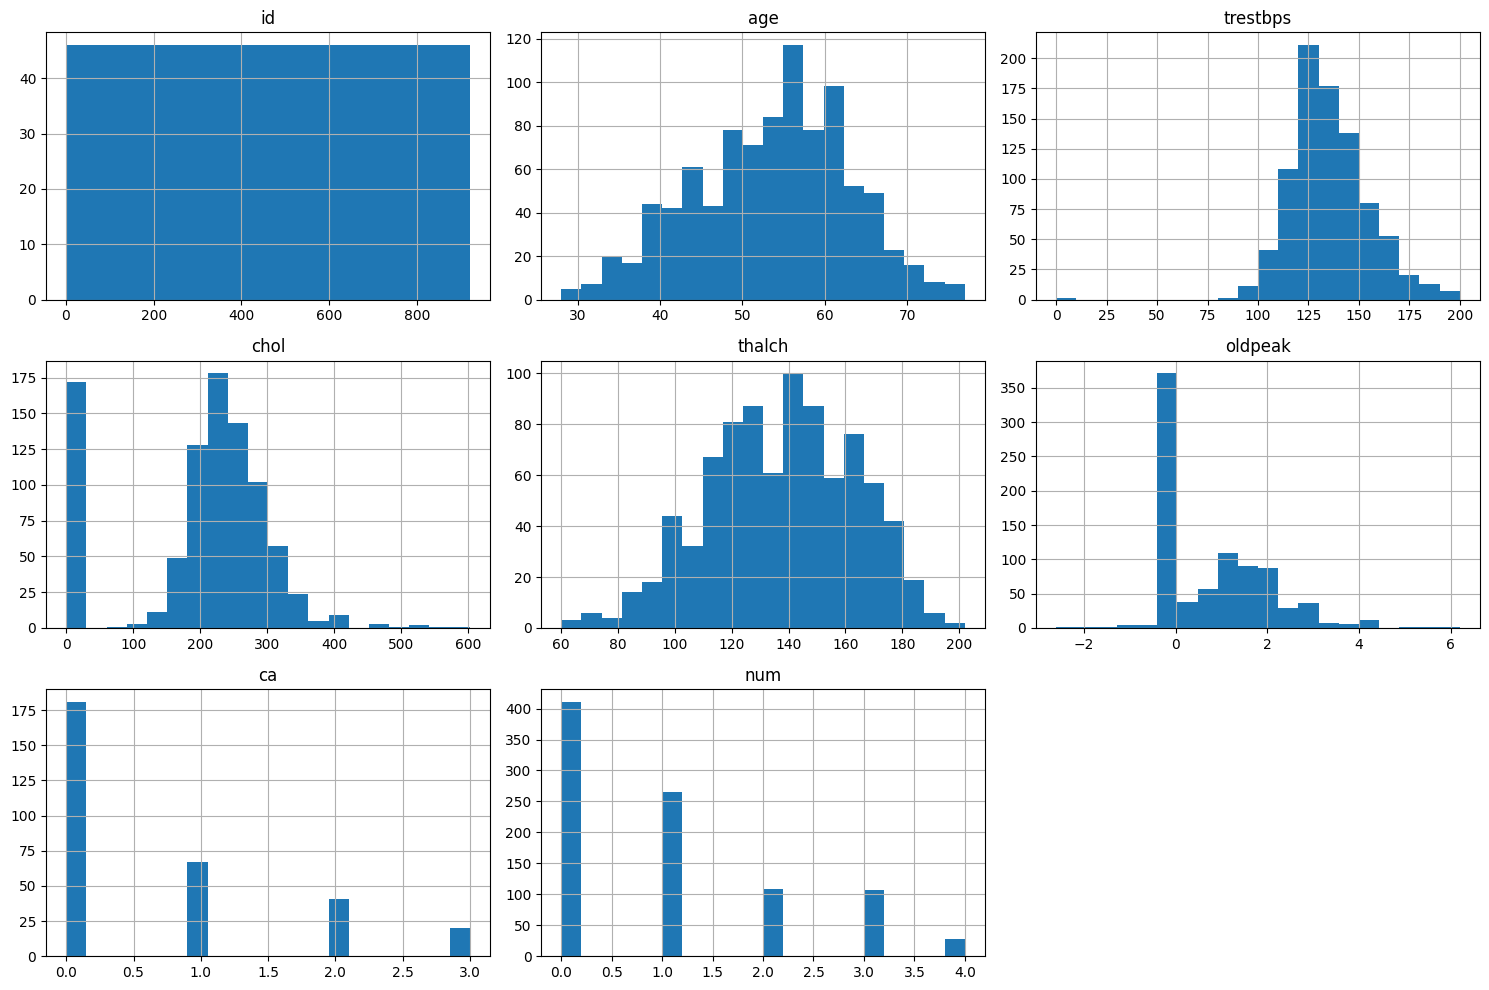

In [10]:
plt.figure(figsize=(12, 8))
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [11]:
features_to_drop = ['id', 'dataset', 'num']
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in features_to_drop]

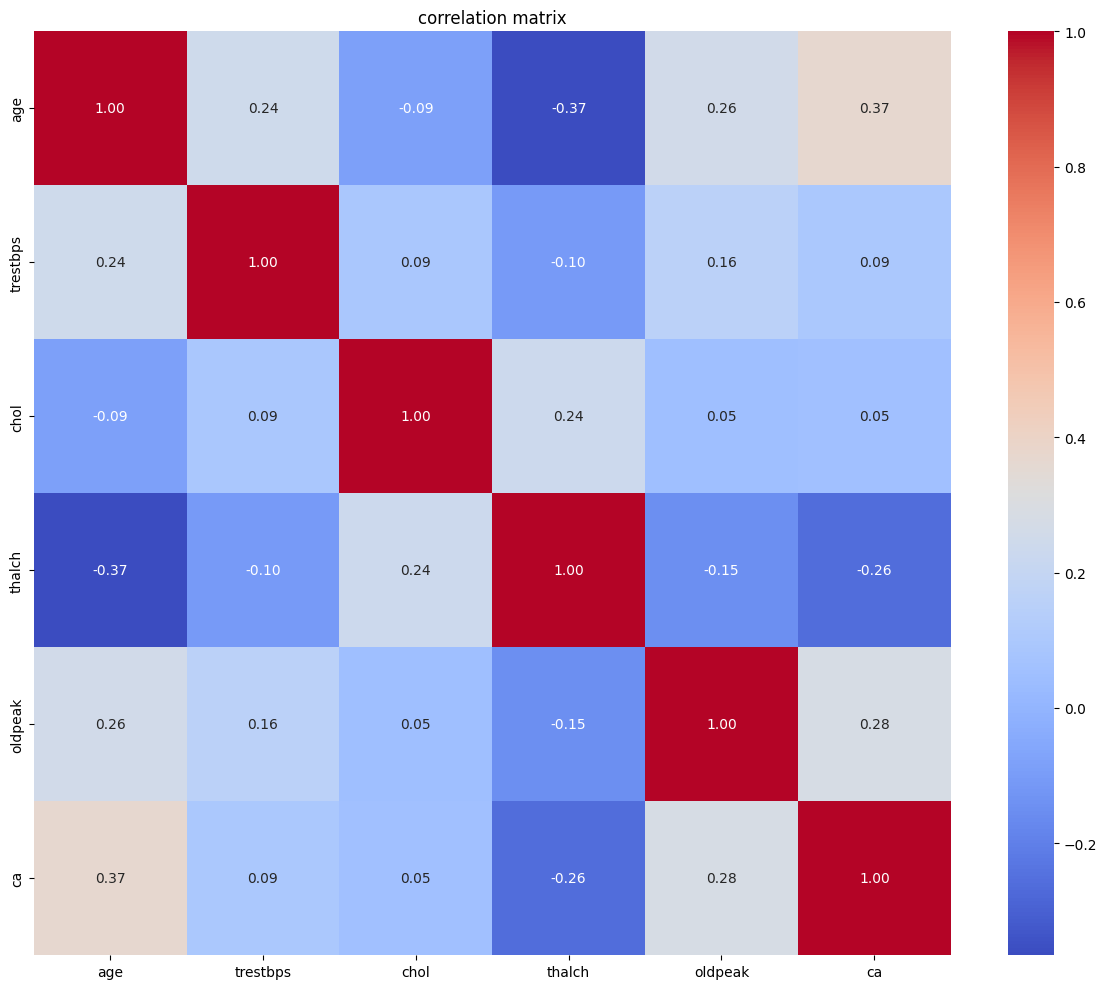

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('correlation matrix')
plt.tight_layout()
plt.show()

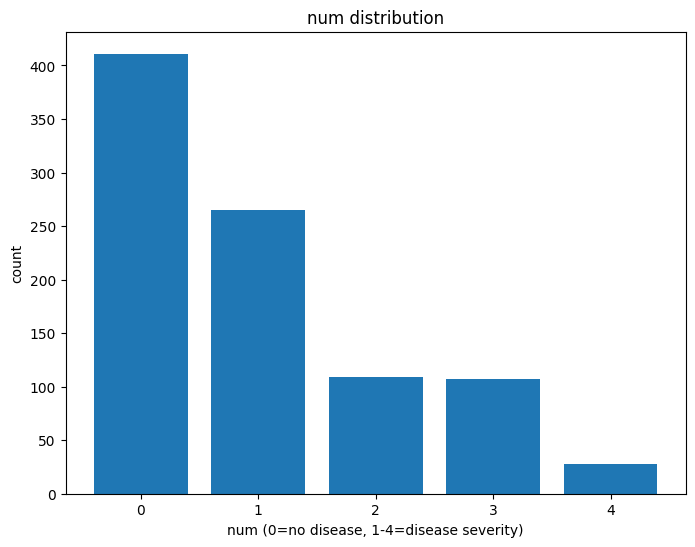

In [13]:
num_counts = df['num'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(num_counts.index, num_counts.values)
plt.xlabel('num (0=no disease, 1-4=disease severity)')
plt.ylabel('count')
plt.title('num distribution')
plt.xticks(num_counts.index)
plt.show()

In [14]:
X = df.drop(['id', 'dataset', 'num'], axis=1)
y = (df['num'] > 0).astype(int)

In [19]:
print("\nfeatures before encoding:")
print(X.columns.tolist())
print("\ndata types:")
print(X.dtypes)


features before encoding:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

data types:
age           int64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
dtype: object


In [29]:
print("\nmissing values in features:")
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])


missing values in features:
trestbps     59
chol         30
thalch       55
oldpeak      62
ca          611
dtype: int64


In [30]:
if X.isnull().sum().sum() > 0:
    print("\nhandling missing values...")
    from sklearn.impute import SimpleImputer

    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    if numeric_cols:
        imputer_numeric = SimpleImputer(strategy='median')
        X[numeric_cols] = imputer_numeric.fit_transform(X[numeric_cols])
        print(f"  imputed {len(numeric_cols)} numeric columns with median")

    if categorical_cols:
        imputer_categorical = SimpleImputer(strategy='most_frequent')
        X[categorical_cols] = imputer_categorical.fit_transform(X[categorical_cols])
        print(f"  imputed {len(categorical_cols)} categorical columns with most frequent")



handling missing values...
  imputed 13 numeric columns with median


In [32]:
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nnon-numeric columns found: {non_numeric_cols}")
    print("applying label encoding...")

    from sklearn.preprocessing import LabelEncoder

    for col in non_numeric_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        print(f"  {col}: {le.classes_.tolist()}")

In [33]:
print("\nfeatures after encoding:")
print(X.dtypes)


features after encoding:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalch      float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
dtype: object


In [34]:
print("\nfeatures used for modeling:")
print(X.columns.tolist())
print(f"\ntarget distribution:")
print(f"no disease (0): {(y == 0).sum()}")
print(f"disease (1): {(y == 1).sum()}")
print(f"class balance: {(y == 1).sum() / len(y):.2%} disease cases")


features used for modeling:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

target distribution:
no disease (0): 411
disease (1): 509
class balance: 55.33% disease cases


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
print(f"\ntraining set: {X_train.shape[0]} samples")
print(f"test set: {X_test.shape[0]} samples")


training set: 736 samples
test set: 184 samples


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
models = {
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'svm': SVC(probability=True, random_state=42),
    'knn': KNeighborsClassifier(),
    'naive_bayes': GaussianNB()
}

In [39]:
results = {}


training logistic_regression...
logistic_regression results:
accuracy: 0.8098
precision: 0.8190
recall: 0.8431
f1 score: 0.8309
roc auc: 0.9018
confusion matrix:
[[63 19]
 [16 86]]
true negatives: 63, false positives: 19
false negatives: 16, true positives: 86
false negative rate: 0.1569


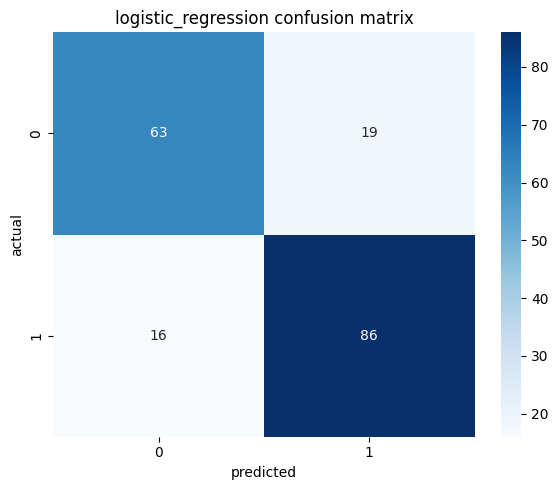


training decision_tree...
decision_tree results:
accuracy: 0.7772
precision: 0.7798
recall: 0.8333
f1 score: 0.8057
roc auc: 0.7703
confusion matrix:
[[58 24]
 [17 85]]
true negatives: 58, false positives: 24
false negatives: 17, true positives: 85
false negative rate: 0.1667


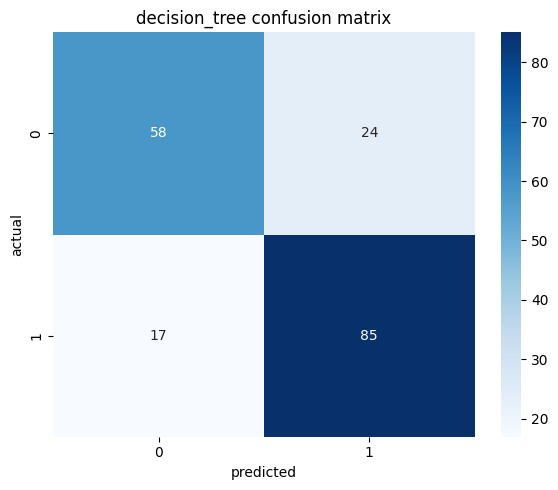


training random_forest...
random_forest results:
accuracy: 0.8424
precision: 0.8476
recall: 0.8725
f1 score: 0.8599
roc auc: 0.9121
confusion matrix:
[[66 16]
 [13 89]]
true negatives: 66, false positives: 16
false negatives: 13, true positives: 89
false negative rate: 0.1275


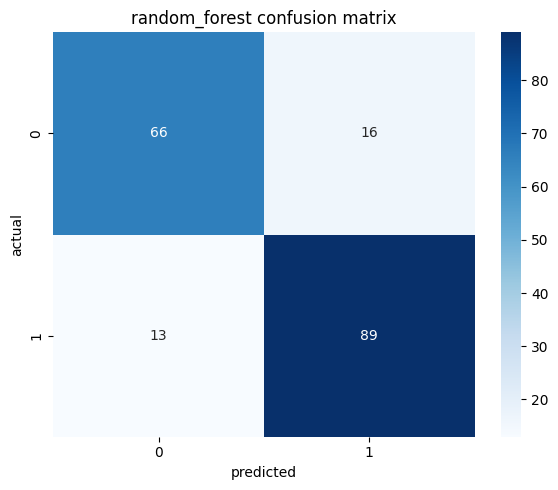


training gradient_boosting...
gradient_boosting results:
accuracy: 0.8533
precision: 0.8571
recall: 0.8824
f1 score: 0.8696
roc auc: 0.9086
confusion matrix:
[[67 15]
 [12 90]]
true negatives: 67, false positives: 15
false negatives: 12, true positives: 90
false negative rate: 0.1176


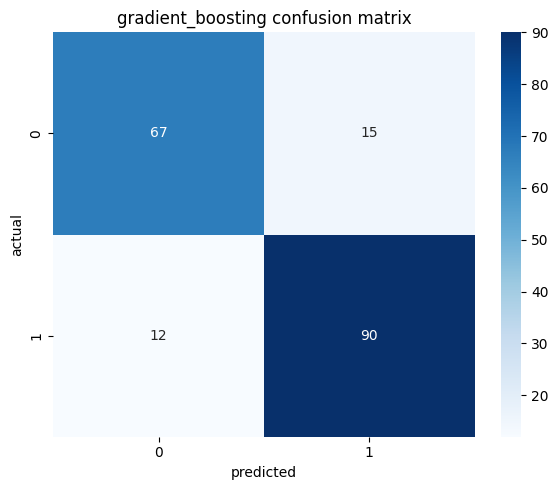


training svm...
svm results:
accuracy: 0.8370
precision: 0.8333
recall: 0.8824
f1 score: 0.8571
roc auc: 0.9082
confusion matrix:
[[64 18]
 [12 90]]
true negatives: 64, false positives: 18
false negatives: 12, true positives: 90
false negative rate: 0.1176


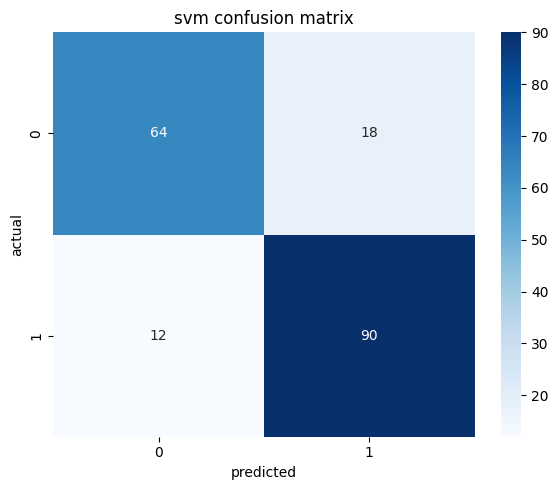


training knn...
knn results:
accuracy: 0.8261
precision: 0.8723
recall: 0.8039
f1 score: 0.8367
roc auc: 0.8855
confusion matrix:
[[70 12]
 [20 82]]
true negatives: 70, false positives: 12
false negatives: 20, true positives: 82
false negative rate: 0.1961


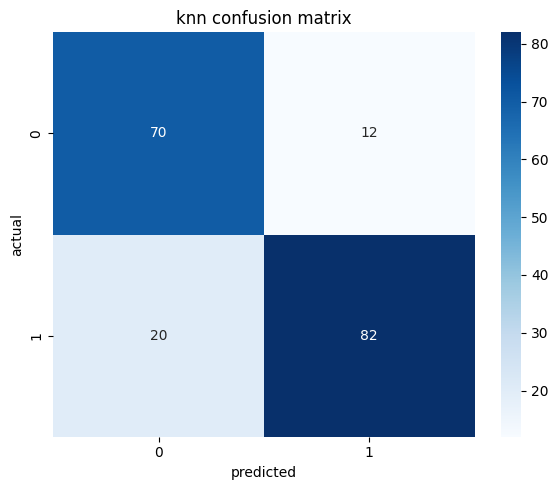


training naive_bayes...
naive_bayes results:
accuracy: 0.8098
precision: 0.8252
recall: 0.8333
f1 score: 0.8293
roc auc: 0.8780
confusion matrix:
[[64 18]
 [17 85]]
true negatives: 64, false positives: 18
false negatives: 17, true positives: 85
false negative rate: 0.1667


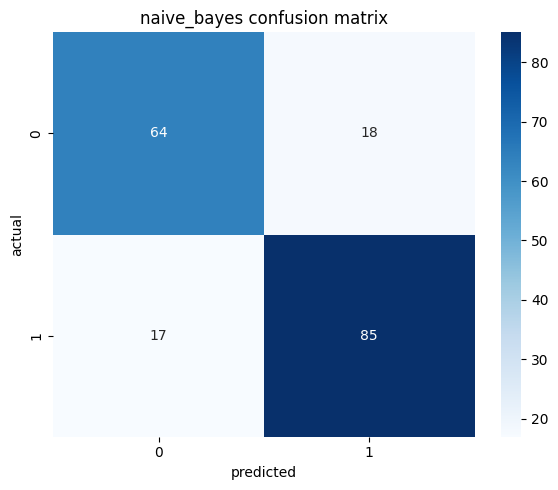

In [40]:
for name, model in models.items():
    print(f"\ntraining {name}...")

    if name in ['svm', 'knn', 'logistic_regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'uses_scaling': name in ['svm', 'knn', 'logistic_regression']
    }

    print(f'{name} results:')
    print(f'accuracy: {accuracy:.4f}')
    print(f'precision: {precision:.4f}')
    print(f'recall: {recall:.4f}')
    print(f'f1 score: {f1:.4f}')
    print(f'roc auc: {roc_auc:.4f}')
    print(f'confusion matrix:\n{cm}')

    tn, fp, fn, tp = cm.ravel()
    print(f'true negatives: {tn}, false positives: {fp}')
    print(f'false negatives: {fn}, true positives: {tp}')
    print(f'false negative rate: {fn/(fn+tp):.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} confusion matrix')
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame({
    'model': list(results.keys()),
    'accuracy': [results[k]['accuracy'] for k in results.keys()],
    'precision': [results[k]['precision'] for k in results.keys()],
    'recall': [results[k]['recall'] for k in results.keys()],
    'f1': [results[k]['f1'] for k in results.keys()],
    'roc_auc': [results[k]['roc_auc'] for k in results.keys()]
})

In [41]:
results_df = results_df.sort_values('recall', ascending=False)
print('\nmodel comparison sorted by recall:')
print(results_df.to_string(index=False))


model comparison sorted by recall:
              model  accuracy  precision   recall       f1  roc_auc
  gradient_boosting  0.853261   0.857143 0.882353 0.869565 0.908596
                svm  0.836957   0.833333 0.882353 0.857143 0.908178
      random_forest  0.842391   0.847619 0.872549 0.859903 0.912064
logistic_regression  0.809783   0.819048 0.843137 0.830918 0.901841
      decision_tree  0.777174   0.779817 0.833333 0.805687 0.770325
        naive_bayes  0.809783   0.825243 0.833333 0.829268 0.878049
                knn  0.826087   0.872340 0.803922 0.836735 0.885521


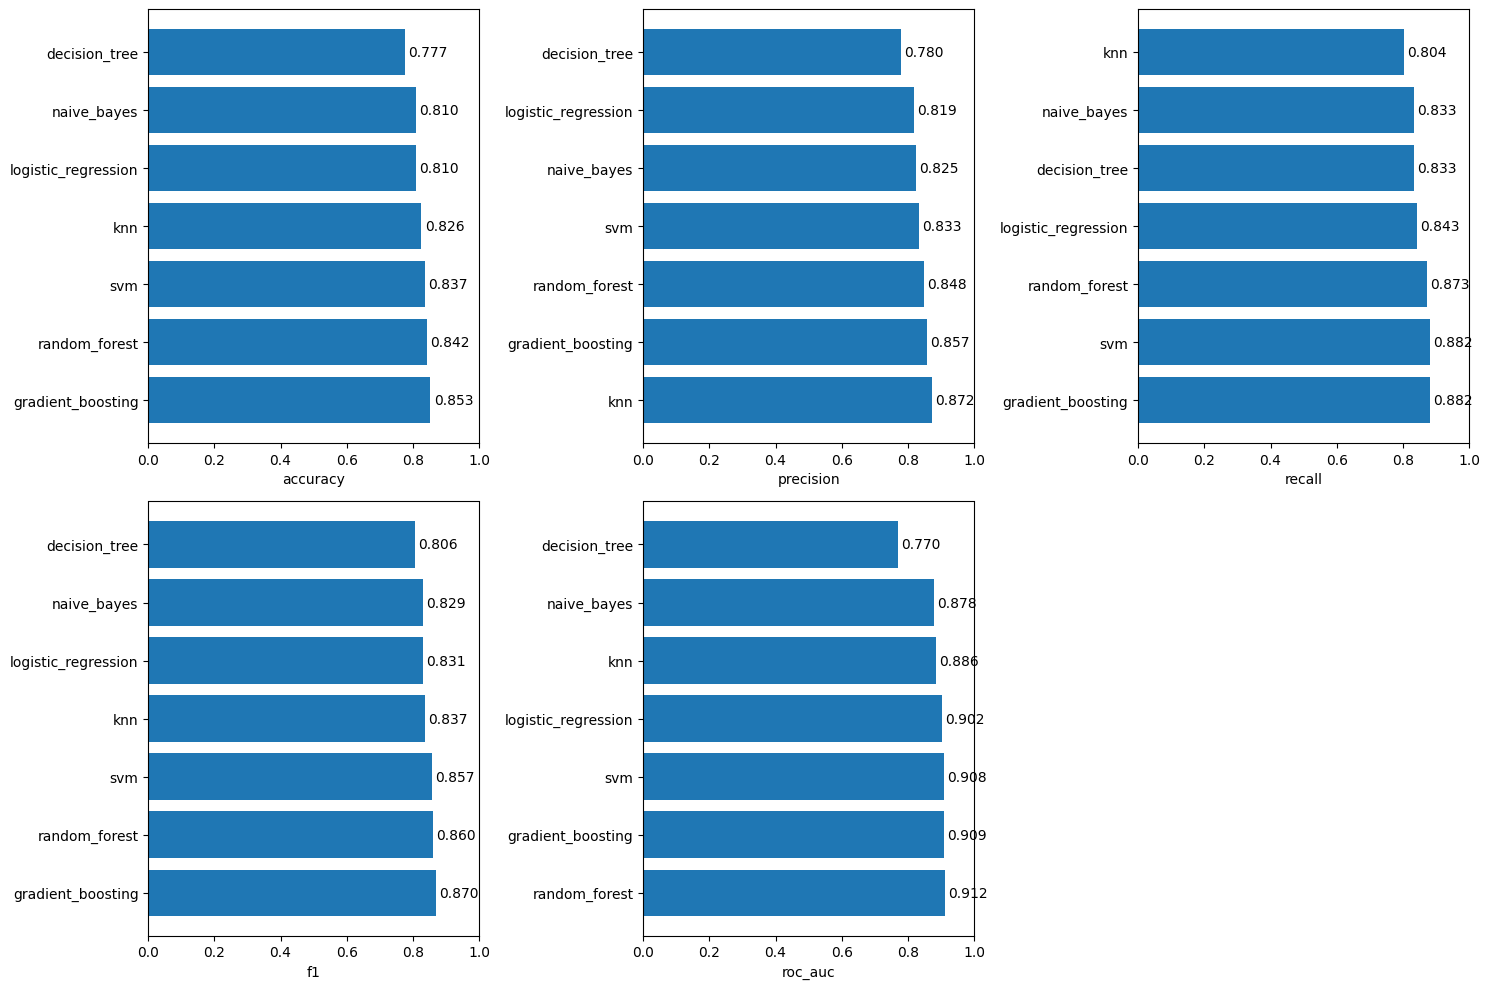

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    sorted_data = results_df.sort_values(metric, ascending=False)
    ax.barh(sorted_data['model'], sorted_data[metric])
    ax.set_xlabel(metric)
    ax.set_xlim(0, 1)
    for i, v in enumerate(sorted_data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

In [43]:
best_model_name = results_df.iloc[0]['model']
best_model = results[best_model_name]['model']

In [44]:
print(f'\nbest model selected: {best_model_name}')
print(f'best recall score: {results[best_model_name]["recall"]:.4f}')
print(f'accuracy: {results[best_model_name]["accuracy"]:.4f}')
print(f'precision: {results[best_model_name]["precision"]:.4f}')
print(f'f1 score: {results[best_model_name]["f1"]:.4f}')
print(f'roc auc: {results[best_model_name]["roc_auc"]:.4f}')


best model selected: gradient_boosting
best recall score: 0.8824
accuracy: 0.8533
precision: 0.8571
f1 score: 0.8696
roc auc: 0.9086


In [52]:
if results[best_model_name]['uses_scaling']:
    model_for_export = Pipeline([
        ('scaler', scaler),
        ('model', best_model)
    ])
else:
    model_for_export = best_model

initial_type = [('input', FloatTensorType([None, X.shape[1]]))]

onnx_model = convert_sklearn(model_for_export, initial_types=initial_type)

with open('best_model.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())


In [45]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [46]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [49]:
model_metadata = {
    'best_model': best_model_name,
    'metrics': {
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1_score': results[best_model_name]['f1'],
        'roc_auc': results[best_model_name]['roc_auc']
    },
    'uses_scaling': results[best_model_name]['uses_scaling'],
    'features': X.columns.tolist(),
    'num_features': len(X.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)